In [95]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller

In [96]:
df_train=pd.read_csv('Train.csv',parse_dates=['Date'],index_col='Date')
df_test=pd.read_csv('Test_x.csv',parse_dates=['Date'],index_col='Date')
df_train.head()

,Stock,liabilities,equity,total_assets,current_assets,current_liabilities,total_revenue,net_income,dividend,shares_outstanding,price
Date,,,,,,,,,,,
2006-07-31,Stock 1,625.898686,925.086518,1550.985204,675.789905,555.931329,548.488451,251.282553,68.184030,1040831,100.000000
2006-08-31,Stock 1,407.387467,903.249093,1310.636561,1023.110983,1295.186240,513.446432,207.576940,42.232672,1046649,101.924169
2006-09-29,Stock 1,464.069891,602.668832,1066.738722,709.711673,598.719338,503.519871,133.719700,28.835722,1094158,103.166191
2006-10-31,Stock 1,855.854937,391.375369,1247.230306,649.979564,733.594339,596.006397,-76.881818,0.000000,1018574,104.478956
2006-11-30,Stock 1,453.954969,956.490566,1410.445534,1115.594551,1152.274711,965.939247,-309.204301,0.000000,1036293,104.160907


Renaming columns for easier use

In [97]:
df_train.rename(columns={'liabilities':'TL',
                 'equity':'E',
                 'total_assets':'TA',
                 'current_assets':'CA',
                 'current_liabilities':'CL',
                 'total_revenue':'TR',
                 'net_income':'NI',
                 'dividend':'D',
                 'shares_outstanding':'SO'
                 },inplace=True)

Encoding 'Stock' column

In [98]:
def no(s):
    return np.int(s.split()[-1])
df_train['stock_no']=df_train['Stock'].apply(no)
df_train.drop(columns=['Stock'],inplace=True)

C:\Users\jains\AppData\Local\Temp\ipykernel_16616\1372489550.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.int(s.split()[-1])


In [5]:
df_train.shape,df_test.shape

((15000, 11), (5000, 10))

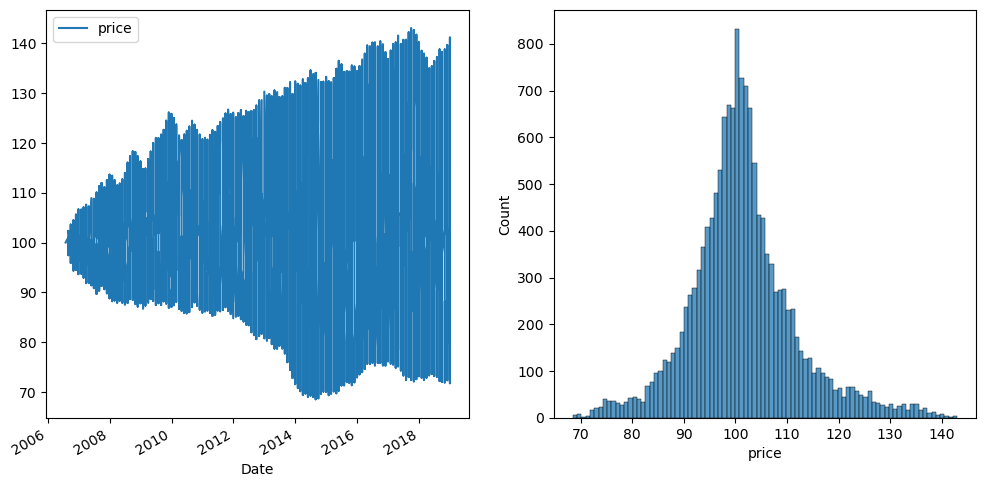

In [8]:
fig=plt.figure(figsize=(12,6))
ax1=fig.add_subplot(1,2,1)
df_train.plot(y='price',ax=ax1)
ax2=fig.add_subplot(1,2,2)
sns.histplot(df_train.price,ax=ax2)
plt.show()

### Test for stationarity of series

In [99]:
# Stationarity tests
def is_stationary(timeseries,diff=0):
    s=timeseries.price
    if(diff>0):
        s=(s-s.shift(diff))[diff:]
    test = adfuller(s, autolag='AIC')
    if(test[1]<0.05):
        return True
    return False

In [14]:
df_train.groupby('stock_no').apply(is_stationary,diff=0).sum()

6

Taking first difference

In [15]:
df_train.groupby('stock_no').apply(is_stationary,diff=1).sum()

100

### Data Preprocessing

- Creating price change column

In [100]:
price_train=pd.DataFrame(df_train[['stock_no','price']])
def price_diff(group):
    group['price_change']=group.price-group.price.shift(1)
    return group
price_train=price_train.groupby('stock_no').apply(price_diff)

In [101]:
df_train.drop(columns=['price'],inplace=True)

- Feature Creation using domain knowledge

In [102]:
df_train['d_to_e']=df_train.TL/df_train.E
df_train['debt_ratio']=df_train.TL/df_train.TA 
df_train['current_ratio']=df_train.CA/df_train.CL 
df_train['profit_margin']=df_train.NI/df_train.TR 
df_train['dpr']=df_train.D/df_train.NI 
df_train['eps']=df_train.NI/df_train.SO 
df_train['equity_ratio']=df_train.E/df_train.TA
df_train['total_income']=df_train.NI+df_train.D

- Shifting the features by one entry

In [103]:
def shift_feature(group):
    return group.shift(1).iloc[1:]
grp=df_train.groupby('stock_no')
shift_df=grp.apply(shift_feature)
shift_df=shift_df.drop(columns=['stock_no']).reset_index().set_index('Date')

In [104]:
size=shift_df.groupby('stock_no').get_group(1).shape[0]

- Creating Change features

In [105]:
def change_feature(group):
    return (group - group.shift(1)).iloc[1:]
grp=df_train.groupby('stock_no')
change_df=grp.apply(change_feature)
change_df=change_df.drop(columns=['stock_no']).reset_index().set_index('Date')

- Testing for the lag features

In [106]:
sample=76
df_temp=price_train.query(f'stock_no == {sample}').drop(columns=['stock_no'])
price_change=df_temp.price_change

c:\Users\jains\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


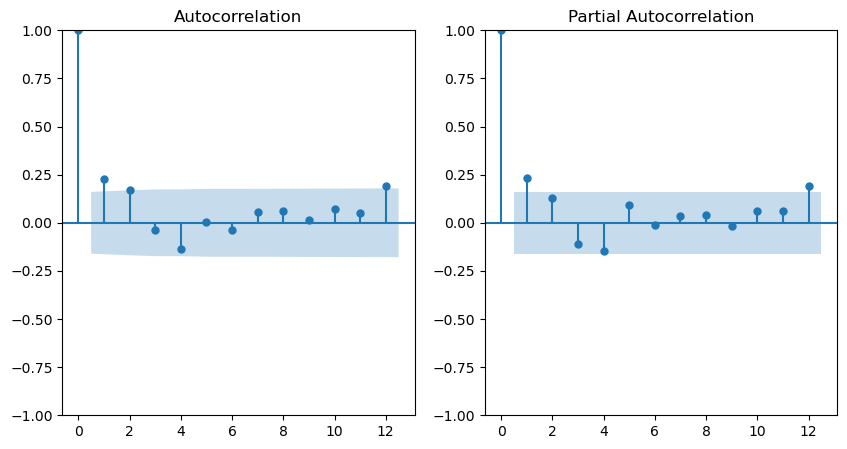

In [15]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig=plt.figure(figsize=(10,5))
ax1=fig.add_subplot(1,2,1)
# Autocorrelation of price
plot_acf(price_change.values[1:],lags=12,ax=ax1)
ax2=fig.add_subplot(1,2,2)
plot_pacf(price_change.values[1:],lags=12,ax=ax2)
plt.show()

- Using Correlation Plot for removing columns with multicollinearity (feature selection)

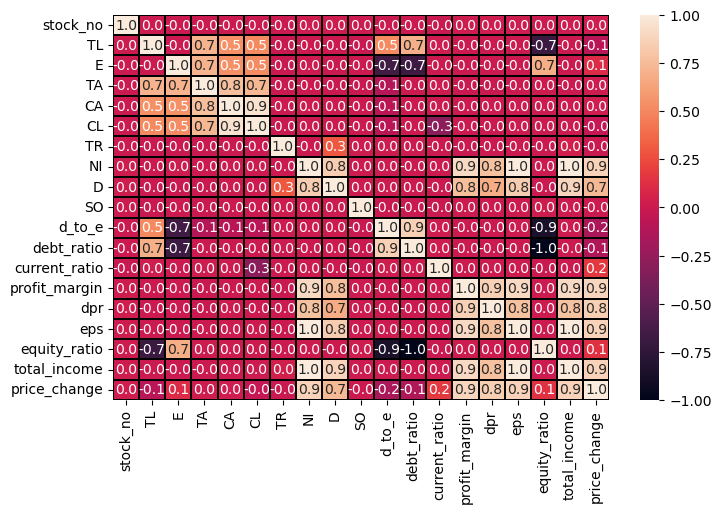

In [107]:
temp=shift_df.copy()
temp['price_change']=price_train.price_change[price_train.price_change.notnull()].values.reshape(-1, 1)
plt.figure(figsize=(8,5))
plot=sns.heatmap(temp.corr(),annot=True,fmt='.1f',linewidths=0.005,linecolor='black')

In [108]:
shift_feature_select=np.array(['TL','E','d_to_e','current_ratio','profit_margin','dpr','eps','total_income'])
shift_select=pd.DataFrame(shift_df[shift_feature_select].values,columns=[i+'_shift' for i in shift_feature_select])

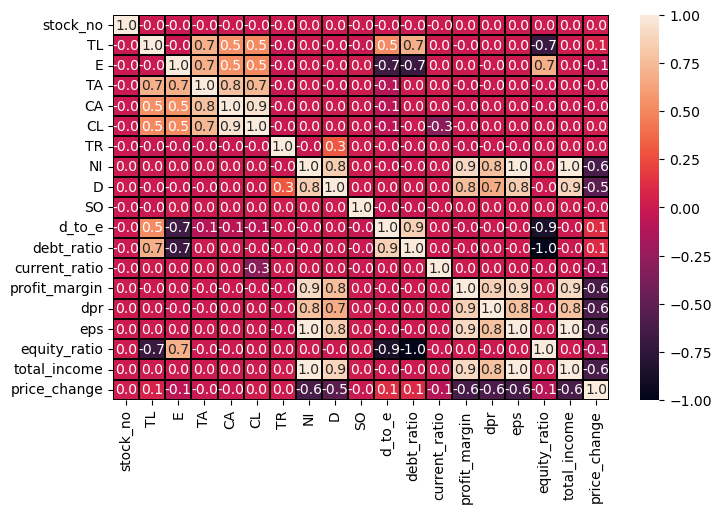

In [48]:
temp=change_df.copy()
temp['price_change']=price_train.price_change[price_train.price_change.notnull()].values.reshape(-1, 1)
plt.figure(figsize=(8,5))
plot=sns.heatmap(temp.corr(),annot=True,fmt='.1f',linewidths=0.005,linecolor='black')

In [109]:
change_feature_select=['TL','E','d_to_e','profit_margin','dpr','eps','total_income']
change_select=pd.DataFrame(change_df[change_feature_select].values,columns=[i+'_change' for i in change_feature_select])

- Scaling the input features

In [111]:
feature_select=pd.concat([shift_select,change_select],axis=1)

In [112]:
from sklearn.preprocessing import StandardScaler
#scale values
scale_x=StandardScaler()
scale_y=StandardScaler()
feature_scale=pd.DataFrame(scale_x.fit_transform(feature_select),index=feature_select.index)
y=scale_y.fit_transform(price_train.price_change[price_train.price_change.notnull()].values.reshape(-1, 1))

In [24]:
feature_scale.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.304457,1.443019,-0.551588,1.785250,1.558586,1.133959,1.429674,1.513985,-0.592165,-0.059230,-0.119679,-0.131412,-0.379027,-0.182596,-0.249374
1,-0.537075,1.359137,-0.721932,-1.334761,1.372853,0.598131,1.171691,1.161482,0.154706,-0.813456,0.170075,-0.338943,0.067965,-0.322599,-0.312469
2,-0.318779,0.204551,-0.481021,1.563771,0.894468,0.694324,0.716102,0.719928,1.064170,-0.571862,0.754181,-0.964675,-1.203806,-0.838197,-0.858124
3,1.190067,-0.607068,0.588930,-0.630471,-0.466295,-1.007692,-0.467228,-0.491757,-1.089879,1.528955,-0.910693,-0.467098,-0.000067,-0.945080,-0.832614
4,-0.357734,1.563648,-0.704124,-0.028359,-1.125398,-1.007692,-1.801417,-1.667437,1.259158,-2.072406,2.308922,1.949743,1.355052,2.567093,2.494333


- feature selection using SequentialFeatureSelector

In [113]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit

In [114]:
%%capture --no-stdout
tscv = TimeSeriesSplit(n_splits=2, test_size=50)
rf=RandomForestRegressor(
                        max_depth=10,
                        min_samples_split=7,
                        min_samples_leaf=3,
                        max_features=0.5,
                        n_jobs=-1
                        )
sfs = SequentialFeatureSelector(rf,scoring='neg_root_mean_squared_error',cv=tscv,n_jobs=-1)
sfs.fit(feature_scale,y)

In [80]:
sfs.n_features_to_select_,feature_scale.columns[sfs.support_]

(7, Int64Index([0, 1, 3, 4, 5, 6, 7], dtype='int64'))

In [73]:
feature_sfs_selected=feature_scale.iloc[:,sfs.support_]

- Creating number of working days column

In [110]:
date=df_train.groupby('stock_no').get_group(1).index.date
l=[]
for i in range(len(date)-1):
    l.append(np.busday_count(date[i],date[i+1]))
working_day=np.array(l)
days=[]
for i in range(100):
    days.append(working_day)
working_days_all=np.array(days).flatten()
print("min working days :",working_days_all.min())
#scale working days
working_days_all=working_days_all-20
print("min working days :",working_days_all.min())

min working days : 20
min working days : 0


- joining the 2 sets of features

In [74]:
feature_sfs_selected['stock_no']=shift_df.stock_no.values
feature_sfs_selected['quarter']=shift_df.index.quarter
feature_sfs_selected['working_day']=working_days_all
feature_sfs_selected=pd.get_dummies(feature_sfs_selected,columns=['stock_no'])

C:\Users\jains\AppData\Local\Temp\ipykernel_16616\2841567555.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_sfs_selected['stock_no']=shift_df.stock_no.values
C:\Users\jains\AppData\Local\Temp\ipykernel_16616\2841567555.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_sfs_selected['quarter']=shift_df.index.quarter
C:\Users\jains\AppData\Local\Temp\ipykernel_16616\2841567555.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

### Modeling

In [75]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor

In [76]:
X=feature_sfs_selected
y=y

In [77]:
rf=RandomForestRegressor(n_estimators=300,
                        max_depth=10,
                        min_samples_split=7,
                        min_samples_leaf=3,
                        max_features=0.5,
                        n_jobs=-1
                        )
lr=LinearRegression()
model=VotingRegressor([('lr',lr),('rf',rf)])
model.fit(X,y)

c:\Users\jains\anaconda3\lib\site-packages\sklearn\ensemble\_voting.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jains\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\jains\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


VotingRegressor(estimators=[('lr', LinearRegression()),
                            ('rf',
                             RandomForestRegressor(bootstrap=False,
                                                   max_depth=10,
                                                   max_features=0.5,
                                                   min_samples_leaf=3,
                                                   min_samples_split=7,
                                                   n_estimators=300,
                                                   n_jobs=-1))])

### Predicting on test data

In [78]:
df_test.rename(columns={'liabilities':'TL',
                 'equity':'E',
                 'total_assets':'TA',
                 'current_assets':'CA',
                 'current_liabilities':'CL',
                 'total_revenue':'TR',
                 'net_income':'NI',
                 'dividend':'D',
                 'shares_outstanding':'SO'
                 },inplace=True)
df_test['stock_no']=df_test['Stock'].apply(no)
df_test.drop(columns=['Stock'],inplace=True)

C:\Users\jains\AppData\Local\Temp\ipykernel_16616\1372489550.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.int(s.split()[-1])


In [79]:
df_test['d_to_e']=df_test.TL/df_test.E
df_test['debt_ratio']=df_test.TL/df_test.TA 
df_test['current_ratio']=df_test.CA/df_test.CL 
df_test['profit_margin']=df_test.NI/df_test.TR 
df_test['dpr']=df_test.D/df_test.NI 
df_test['eps']=df_test.NI/df_test.SO 
df_test['equity_ratio']=df_test.E/df_test.TA
df_test['total_income']=df_test.NI+df_test.D

In [80]:
base=df_train.reset_index().groupby('stock_no').last().reset_index()

In [81]:
def add_row(group,base):
    index=group.stock_no.values[0]
    val=base.iloc[index-1].to_list()
    value=val[1:11]
    value.append(index)
    value.extend(val[11:])
    row=pd.DataFrame([value],columns=group.columns)
    return pd.concat([row,group],axis=0,ignore_index=True)

In [82]:
grp=df_test.reset_index().groupby('stock_no')
df_test=grp.apply(add_row,base=base).set_index('Date')

In [83]:
grp=df_test.groupby('stock_no')
shift_df=grp.apply(shift_feature)
shift_df=shift_df.drop(columns=['stock_no']).reset_index().set_index('Date')
change_df=grp.apply(change_feature)
change_df=change_df.drop(columns=['stock_no']).reset_index().set_index('Date')

In [84]:
size=shift_df.groupby('stock_no').get_group(1).shape[0]

In [85]:
shift_feature_select=np.array(['TL','E','d_to_e','current_ratio','profit_margin','dpr','eps','total_income'])
shift_select=pd.DataFrame(shift_df[shift_feature_select].values,columns=[i+'_shift' for i in shift_feature_select])
change_feature_select=['TL','E','d_to_e','profit_margin','dpr','eps','total_income']
change_select=pd.DataFrame(change_df[change_feature_select].values,columns=[i+'_change' for i in change_feature_select])

In [87]:
feature_select=pd.concat([shift_select,change_select],axis=1)
feature_scale=pd.DataFrame(scale_x.transform(feature_select),index=feature_select.index)
y=scale_y.transform(price_train.price_change[price_train.price_change.notnull()].values.reshape(-1, 1))

In [88]:
feature_sfs_selected=feature_scale.iloc[:,sfs.support_]

In [86]:
date=df_test.groupby('stock_no').get_group(1).index.date
l=[]
for i in range(len(date)-1):
    l.append(np.busday_count(date[i],date[i+1]))
working_day=np.array(l)
days=[]
for i in range(100):
    days.append(working_day)
working_days_all=np.array(days).flatten()
#scale working days
working_days_all=working_days_all-20
print("min working days :",working_days_all.min())

min working days : 0


In [89]:
feature_sfs_selected['stock_no']=shift_df.stock_no.values
feature_sfs_selected['quarter']=shift_df.index.quarter
feature_sfs_selected['working_day']=working_days_all
feature_sfs_selected=pd.get_dummies(feature_sfs_selected,columns=['stock_no'])

C:\Users\jains\AppData\Local\Temp\ipykernel_16616\2841567555.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_sfs_selected['stock_no']=shift_df.stock_no.values
C:\Users\jains\AppData\Local\Temp\ipykernel_16616\2841567555.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_sfs_selected['quarter']=shift_df.index.quarter
C:\Users\jains\AppData\Local\Temp\ipykernel_16616\2841567555.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [90]:
X=feature_sfs_selected
y_pred=model.predict(X)

c:\Users\jains\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\jains\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


- Taking the Cumulative sum to get price value

In [91]:
base=price_train.groupby('stock_no').last()
if len(y_pred.shape)==1:
    y_pred=scale_y.inverse_transform(np.expand_dims(y_pred,axis=1))
else:
    y_pred=scale_y.inverse_transform(y_pred)

In [92]:
l=[]
for i in range(100):
    bias=base.iloc[i]['price']
    l.append(y_pred[i*size:(i*size)+size].cumsum()+ bias)
price_final=np.array(l).flatten()

In [170]:
submission=pd.DataFrame()
submission['y_pred']=price_final
submission.to_csv('submission.csv',index=False)